In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
def plot_confusion_matrix(y_test, y_hat, model, class_names):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot()
    plt.rcParams["font.size"] = "11"
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.show()

In [3]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Credit_Risk')

In [4]:
###################
#%% Read data
###################

In [5]:
analysis_data = pd.read_csv('analysis_data.csv')                          

In [6]:
### Select all numerical and string variables:
numeric_columns = analysis_data.select_dtypes(exclude=['object']).columns
categorical_columns = analysis_data.select_dtypes(include=['object']).columns

In [7]:
##########################################################
##########################################################
#%% Analysis data - prepare for analysis
##########################################################
##########################################################

In [8]:
##########################################################
#%% Label encoding the non-numeric columns

In [9]:
labelencoder = LabelEncoder()

# apply "le.fit_transform"
analysis_data = analysis_data.apply(labelencoder.fit_transform)
print(analysis_data.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


In [10]:
##########################################################
#%% Train-Test Set

In [11]:
X = analysis_data.drop('loan_status', axis=1)
y = analysis_data[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# stratify=y garantie the same 'y' distribution

In [12]:
##########################################################
#%% Undersampling training data

In [13]:
def Undersampling_Data(X_tr, y_tr, y_name):
    
    X_y_train = pd.concat([X_tr.reset_index(drop = True),
                           y_tr.reset_index(drop = True)], axis = 1)
    
    count_nondefault, count_default = X_y_train[y_name].value_counts()
    #print(count_nondefault, count_default)

    # Create data sets for defaults and non-defaults
    nondefaults = X_y_train.query(f'{y_name} == 0')
    defaults = X_y_train.query(f'{y_name} == 1')


    # Undersample the non-defaults
    nondefaults_under = nondefaults.sample(count_default)

    # Concatenate the undersampled nondefaults with defaults
    X_y_train_under = pd.concat([nondefaults_under.reset_index(drop=True), defaults.reset_index(drop=True)], axis = 0)

    # Print the value counts for loan status
    #print(X_y_train_under['loan_status'].value_counts())

    X_train_resampled = X_y_train_under.drop(y_name, axis=1)
    y_train_resampled  = X_y_train_under[[y_name]]
    
    return X_train_resampled, y_train_resampled

In [14]:
# Undersampe
X_train, y_train = Undersampling_Data(X_train, y_train, 'loan_status')

In [15]:
##########################################################
##########################################################
#%% XGBoost with label encoding and undersample 
##########################################################
##########################################################

In [16]:
# Define parameters set
xgboost_param_grid = {
                  'n_estimators': [  200, 250,  300, 350, 400, 450, 500],
                  'max_depth': range(2, 9),
                  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                  'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
                  'learning_rate': [ 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
                  'gamma': [0, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
                  'reg_lambda': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1.0],
                  'min_child_weight':[0.01, 0.05, 0.1, 1, 3]
                 }

# Instantiate model
model_xgboost_init = xgb.XGBClassifier()

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

# roc_auc, recall, f1_macro
model_xgboost_random_search = RandomizedSearchCV(param_distributions = xgboost_param_grid,
                                                  estimator = model_xgboost_init,
                                                  scoring = 'roc_auc',
                                                  n_iter = 50,
                                                  cv = 5,
                                                  verbose=1,
                                                  n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_xgboost_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_xgboost_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 0.05, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 0.9}


In [17]:
# Extract the best model
model_xgboost = model_xgboost_random_search.best_estimator_

In [18]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [19]:
preds_proba_xgboost = model_xgboost.predict_proba(X_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.94      4971
     Default       0.74      0.84      0.79      1365

    accuracy                           0.90      6336
   macro avg       0.85      0.88      0.86      6336
weighted avg       0.91      0.90      0.90      6336


AUC score:   0.949

Confusion Matrix:


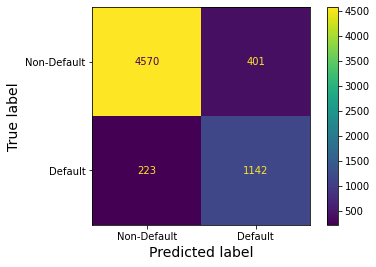

In [20]:
# Create a dataframe for the probabilities of default
preds_df_xgboost = pd.DataFrame(preds_proba_xgboost[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_xgboost['loan_status'] = preds_df_xgboost['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_xgboost['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_xgboost['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_xgboost['loan_status'], model_xgboost, target_names)

In [21]:
##########################################################
##########################################################
#%% XGBoost with label encoding and future selection
##########################################################
##########################################################

In [22]:
# select features
from sklearn.ensemble import ExtraTreesClassifier

feature_selector = ExtraTreesClassifier().fit(X_train, np.ravel(y_train))

importances = pd.DataFrame(feature_selector.feature_importances_,\
                           index=X_train.columns, columns = ['score']).sort_values('score', ascending=False)

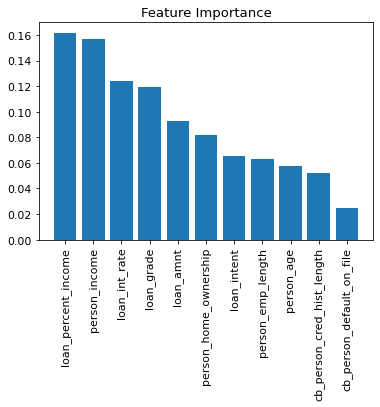

In [23]:
plt.title('Feature Importance')
plt.bar(importances.index, importances.score, align='center')
plt.xticks( rotation=90)
#plt.tight_layout()
plt.show()

In [24]:
# select 6 most important features
selected_features = importances.iloc[:6, :]
selected_features

,score
loan_percent_income,0.161834
person_income,0.157005
loan_int_rate,0.124329
loan_grade,0.119505
loan_amnt,0.092759
person_home_ownership,0.081595


In [25]:
# re-create X train and test sets
X_sel_train = X_train[selected_features.index].copy()
X_sel_test = X_test[selected_features.index].copy()

In [26]:
# Instantiate model
model_xgboost_init_sel = xgb.XGBClassifier()

model_xgboost_random_search_sel = RandomizedSearchCV(param_distributions = xgboost_param_grid,
                                                       estimator = model_xgboost_init_sel,
                                                       scoring = 'roc_auc',
                                                       n_iter = 50,
                                                       cv = 5,
                                                       verbose=1,
                                                       n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_xgboost_random_search_sel.fit(X_sel_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_xgboost_random_search_sel.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 0.5, 'n_estimators': 450, 'min_child_weight': 0.01, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 2.0, 'colsample_bytree': 0.5}


In [27]:
# Extract the best model
model_xgboost_sel = model_xgboost_random_search_sel.best_estimator_

In [28]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [29]:
preds_proba_xgboost_sel = model_xgboost_sel.predict_proba(X_sel_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.89      0.92      4971
     Default       0.67      0.83      0.74      1365

    accuracy                           0.87      6336
   macro avg       0.81      0.86      0.83      6336
weighted avg       0.89      0.87      0.88      6336


AUC score:   0.933

Confusion Matrix:


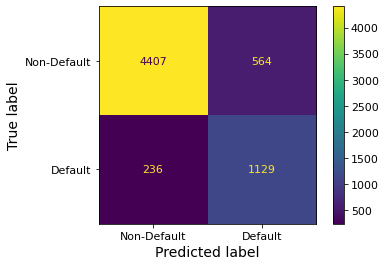

In [30]:
# Create a dataframe for the probabilities of default
preds_df_xgboost_sel  = pd.DataFrame(preds_proba_xgboost_sel[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_xgboost_sel['loan_status'] = preds_df_xgboost_sel['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_xgboost_sel['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_xgboost_sel['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_xgboost_sel['loan_status'], model_xgboost_sel, target_names)

In [31]:
##########################################################
##########################################################
#%% XGBoost with label encoding and future selection based on correlation
##########################################################
##########################################################

In [32]:
##########################################################
#%% Correlation plot

Text(0.5, 1.0, 'Correlation Heatmap')

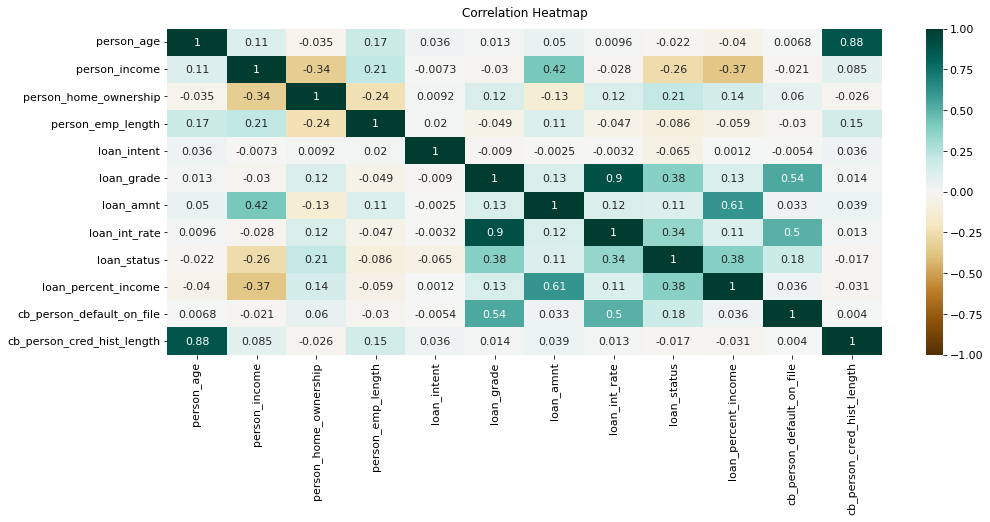

In [33]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(analysis_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

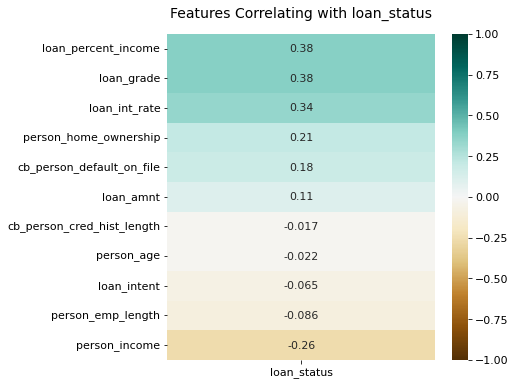

In [34]:
plt.figure(figsize=(6, 6))
y_var_name = 'loan_status'
heatmap = sns.heatmap(analysis_data.corr()[[y_var_name]].sort_values(by=y_var_name, ascending=False).drop(y_var_name)\
                      , vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with loan_status', fontdict={'fontsize':14}, pad=16);

In [35]:
# select 6 the most corelated variables
corr_selected = abs(analysis_data.corr()[[y_var_name]])\
                        .sort_values(by=y_var_name, ascending=False)\
                        .drop(y_var_name).index[:6].to_list()
corr_selected

['loan_percent_income',
 'loan_grade',
 'loan_int_rate',
 'person_income',
 'person_home_ownership',
 'cb_person_default_on_file']

In [36]:
# re-create X train and test sets
X_corr_train = X_train[corr_selected].copy()
X_corr_test = X_test[corr_selected].copy()

In [37]:
# Instantiate model
model_xgboost_init_corr = xgb.XGBClassifier()

model_xgboost_random_search_corr = RandomizedSearchCV(param_distributions = xgboost_param_grid,
                                                       estimator = model_xgboost_init_corr,
                                                       scoring = 'roc_auc',
                                                       n_iter = 50,
                                                       cv = 5,
                                                       verbose=1,
                                                       n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_xgboost_random_search_corr.fit(X_corr_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_xgboost_random_search_corr.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 0.5, 'n_estimators': 450, 'min_child_weight': 0.05, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7}


In [38]:
# Extract the best model
model_xgboost_corr = model_xgboost_random_search_corr.best_estimator_

In [39]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [40]:
preds_proba_xgboost_corr = model_xgboost_corr.predict_proba(X_corr_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.90      0.92      4971
     Default       0.68      0.83      0.75      1365

    accuracy                           0.88      6336
   macro avg       0.82      0.86      0.84      6336
weighted avg       0.89      0.88      0.88      6336


AUC score:   0.933

Confusion Matrix:


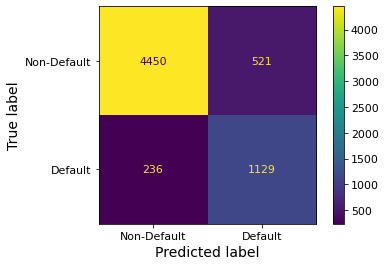

In [41]:
# Create a dataframe for the probabilities of default
preds_df_xgboost_corr  = pd.DataFrame(preds_proba_xgboost_corr[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_xgboost_corr['loan_status'] = preds_df_xgboost_corr['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_xgboost_corr['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_xgboost_corr['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_xgboost_corr['loan_status'], model_xgboost_corr, target_names)

In [42]:
##########################################################
##########################################################
#%% COMPARE MODELS
##########################################################
##########################################################

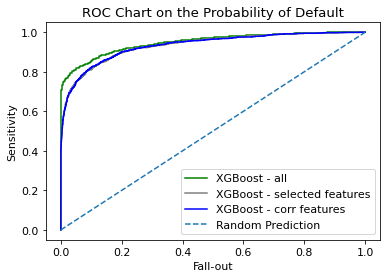

In [43]:
# ROC chart components
fallout_xgboost, sensitivity_xgboost, thresholds_xgboost = roc_curve(y_test, preds_df_xgboost['prob_default'])
fallout_xgboost_sel, sensitivity_xgboost_sel, thresholds_xgboost_sel = roc_curve(y_test, preds_df_xgboost_sel['prob_default'])
fallout_xgboost_corr, sensitivity_xgboost_corr, thresholds_xgboost_corr = roc_curve(y_test, preds_df_xgboost_corr['prob_default'])



# ROC Chart with both
plt.plot(fallout_xgboost, sensitivity_xgboost, color = 'green', label='%s' % 'XGBoost - all')
plt.plot(fallout_xgboost_sel, sensitivity_xgboost_sel, color = 'grey', label='%s' % 'XGBoost - selected features')
plt.plot(fallout_xgboost_corr, sensitivity_xgboost_corr, color = 'blue', label='%s' % 'XGBoost - corr features')


plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [44]:
# Calibration curve

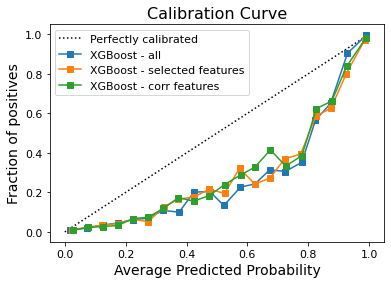

In [45]:
frac_of_pos_xgboost, mean_pred_val_xgboost = calibration_curve(y_test, preds_df_xgboost['prob_default'], n_bins=20)
frac_of_pos_xgboost_sel, mean_pred_val_xgboost_sel = calibration_curve(y_test, preds_df_xgboost_sel['prob_default'], n_bins=20)
frac_of_pos_xgboost_corr, mean_pred_val_xgboost_corr = calibration_curve(y_test, preds_df_xgboost_corr['prob_default'], n_bins=20)


plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_xgboost, frac_of_pos_xgboost, 's-', label='%s' % 'XGBoost - all')
plt.plot(mean_pred_val_xgboost_sel, frac_of_pos_xgboost_sel, 's-', label='%s' % 'XGBoost - selected features')
plt.plot(mean_pred_val_xgboost_corr, frac_of_pos_xgboost_corr, 's-', label='%s' % 'XGBoost - corr features')



plt.ylabel('Fraction of positives', fontsize=14)
plt.xlabel('Average Predicted Probability', fontsize=14)
plt.legend()
plt.title('Calibration Curve', fontsize=16)
plt.show()